# Face Generation


### Get the Data

[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 


<img src='assets/processed_face_data.png' width=60% />


In [2]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Color images with 3 color channels (RGB)

### Pre-process and Load the Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.


In [3]:
import torch
from torchvision import datasets
from torchvision import transforms
import torch.utils.data as data

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    #preprocessig
    transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
    ])

    train_data = datasets.ImageFolder(data_dir, transform=transform)
    train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True) 
    
    return train_data_loader


## Create a DataLoader

In [5]:
# Define function hyperparameters
batch_size = 20
img_size = 32

# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


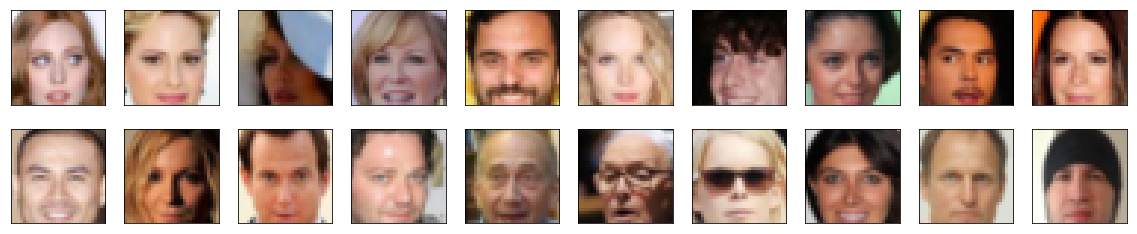

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    return x*2-1


In [8]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
    
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(conv_dim*2)
        self.conv3 = nn.Conv2d(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(conv_dim*4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = F.leaky_relu(self.bn1(x), 0.01)
        
        x = self.conv3(x)
        x = F.leaky_relu(self.bn2(x), 0.01)
        
        #flatten
        x = x.view(-1, self.conv_dim*4*4*4)
        
        out = F.sigmoid(self.fc(x))

        return out

print(Discriminator())
tests.test_discriminator(Discriminator)

Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)
Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim

        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.deconv1 = nn.ConvTranspose2d(conv_dim*4, out_channels=conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.deconv2 = nn.ConvTranspose2d(conv_dim*2, out_channels=conv_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.deconv3 = nn.ConvTranspose2d(conv_dim, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(conv_dim*2)
        self.bn2 = nn.BatchNorm2d(conv_dim)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = self.deconv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.deconv2(x)
        x = self.bn2(x)
        x = F.relu(x)
       
        
        out = F.tanh(self.deconv3(x))

        return out

tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

Reference [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf)


In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if type(m) == nn.Conv2d:
        m.weight.data.normal_(0, 0.02)
        
    elif type(m) == nn.Linear:
        m.weight.data.normal_(0, 0.02)
        m.bias.data.fill_(0)

## Build complete network

In [13]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv3): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): Batch

### Training on GPU

Check boolean variable `train_on_gpu`

In [15]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

In [16]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCELoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCELoss()
    loss = criterion(D_out.squeeze(), labels)
        
    return loss

## Optimizers

In [17]:
import torch.optim as optim
# params
lr = 0.0002
beta1=0.2
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

In [18]:
def train(D, G, n_epochs, print_every=250):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            #train on real images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step() 

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
                
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
        
            # perform backprop
            g_loss.backward()
            g_optimizer.step() 
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [19]:
# set number of epochs 
n_epochs = 40

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   40] | d_loss: 1.3356 | g_loss: 0.6655
Epoch [    1/   40] | d_loss: 0.6644 | g_loss: 2.1952
Epoch [    1/   40] | d_loss: 0.7471 | g_loss: 1.2984
Epoch [    1/   40] | d_loss: 1.0747 | g_loss: 1.0348
Epoch [    1/   40] | d_loss: 1.0582 | g_loss: 0.9507
Epoch [    1/   40] | d_loss: 1.3508 | g_loss: 0.9002
Epoch [    1/   40] | d_loss: 1.3303 | g_loss: 0.9400
Epoch [    1/   40] | d_loss: 1.2100 | g_loss: 0.9945
Epoch [    1/   40] | d_loss: 1.1274 | g_loss: 0.9593
Epoch [    1/   40] | d_loss: 1.1867 | g_loss: 1.0658
Epoch [    1/   40] | d_loss: 1.2084 | g_loss: 0.7082
Epoch [    1/   40] | d_loss: 1.2602 | g_loss: 0.8819
Epoch [    1/   40] | d_loss: 1.3285 | g_loss: 0.9657
Epoch [    1/   40] | d_loss: 1.3283 | g_loss: 0.9381
Epoch [    1/   40] | d_loss: 1.1605 | g_loss: 0.8332
Epoch [    1/   40] | d_loss: 1.2837 | g_loss: 1.2723
Epoch [    1/   40] | d_loss: 1.3216 | g_loss: 0.7929
Epoch [    1/   40] | d_loss: 1.2443 | g_loss: 0.8188
Epoch [    2/   40] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

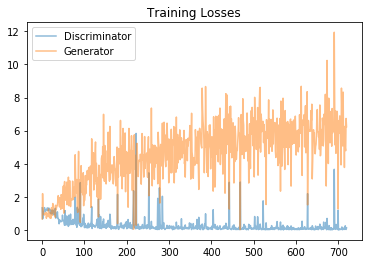

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

In [21]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

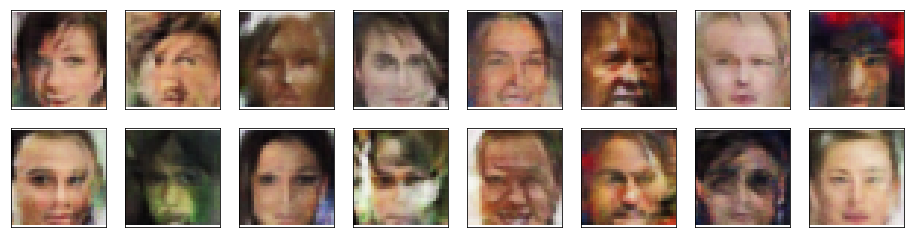

In [23]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** The generated image are not realistically. However, it is apperant that the generated images are faces (sometimes they include some weird colors, maybe from clothes or background). As expected, the overall resolution is relatively low. I tried diffent number of epochs in the range from 10-40. There was no real improvement in generator loss, but more epochs got me a little better pictures. Steps for improvement would be the addition of layers to make the network deeper and adjusting the learning rate.

**Resubmission**: I changed Beta1 from 0.5 to 0.2.